In [1]:
# Basic libraries for data processing
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# PyTorch libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# torchvision for image transformations
from torchvision import transforms

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split
from sklearn.model_selection import train_test_split

In [2]:
# Print all files in the input directory (Kaggle environment)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recognize-digits/sample_submission.csv
/kaggle/input/recognize-digits/train.csv
/kaggle/input/recognize-digits/test.csv


In [3]:
# Define a PyTorch Dataset class for digit recognition
class DigitDataset(Dataset):
    def __init__(self, data, transform=None, has_labels=True):
        self.data = data
        self.transform = transform
        self.has_labels = has_labels

        if self.has_labels:
            self.labels = data['label'].values
            self.images = data.drop('label', axis=1).values
        else:
            self.images = data.values

        self._validate_data()
        self.images = self.images.astype(np.uint8)

    def _validate_data(self):
        expected_cols = 785 if self.has_labels else 784
        if len(self.data.columns) != expected_cols:
            raise ValueError(f"Expected {expected_cols} columns, got {len(self.data.columns)}.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28, 1)
        if self.transform:
            image = self.transform(image)
        return (image, self.labels[idx]) if self.has_labels else image


In [4]:
# Helper function to explore and visualize the dataset
def explore_dataset(dataset, name="Dataset", show_images=True):
    print(f"\n===== {name} Basic Information =====")
    print(f"Number of samples: {len(dataset)}")

    if hasattr(dataset, 'labels'):
        unique_labels, label_counts = np.unique(dataset.labels, return_counts=True)
        print(f"Number of classes: {len(unique_labels)}")
        for label, count in zip(unique_labels, label_counts):
            print(f"Class {label}: {count} samples ({count/len(dataset):.2%})")

        plt.figure(figsize=(10, 5))
        sns.barplot(x=unique_labels, y=label_counts)
        plt.title(f"{name} Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Samples")
        plt.show()

    if show_images:
        plt.figure(figsize=(12, 8))
        for i in range(min(16, len(dataset))):
            plt.subplot(4, 4, i+1)
            img, label = dataset[i] if hasattr(dataset, 'labels') else (dataset[i], "Sample")
            img = img.numpy().transpose(1, 2, 0) if isinstance(img, torch.Tensor) else img
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.suptitle(f"{name} Sample Visualization", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [5]:
# Read data
train_data = pd.read_csv('/kaggle/input/recognize-digits/train.csv')
test_data = pd.read_csv('/kaggle/input/recognize-digits/test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Split training into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Image transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomRotation(10),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


Training data shape: (42000, 785)
Test data shape: (28000, 784)



===== Training Set Basic Information =====
Number of samples: 33600


Number of classes: 10
Class 0: 3305 samples (9.84%)
Class 1: 3747 samples (11.15%)
Class 2: 3342 samples (9.95%)
Class 3: 3481 samples (10.36%)
Class 4: 3258 samples (9.70%)
Class 5: 3036 samples (9.04%)
Class 6: 3310 samples (9.85%)
Class 7: 3521 samples (10.48%)
Class 8: 3250 samples (9.67%)
Class 9: 3350 samples (9.97%)


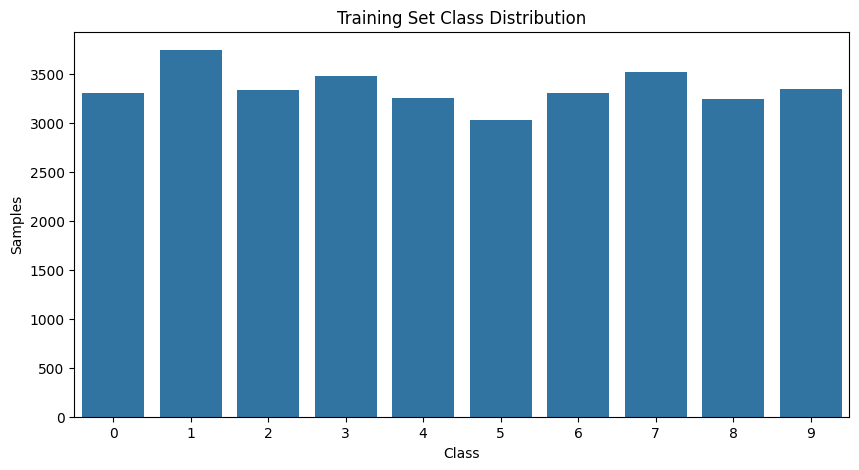

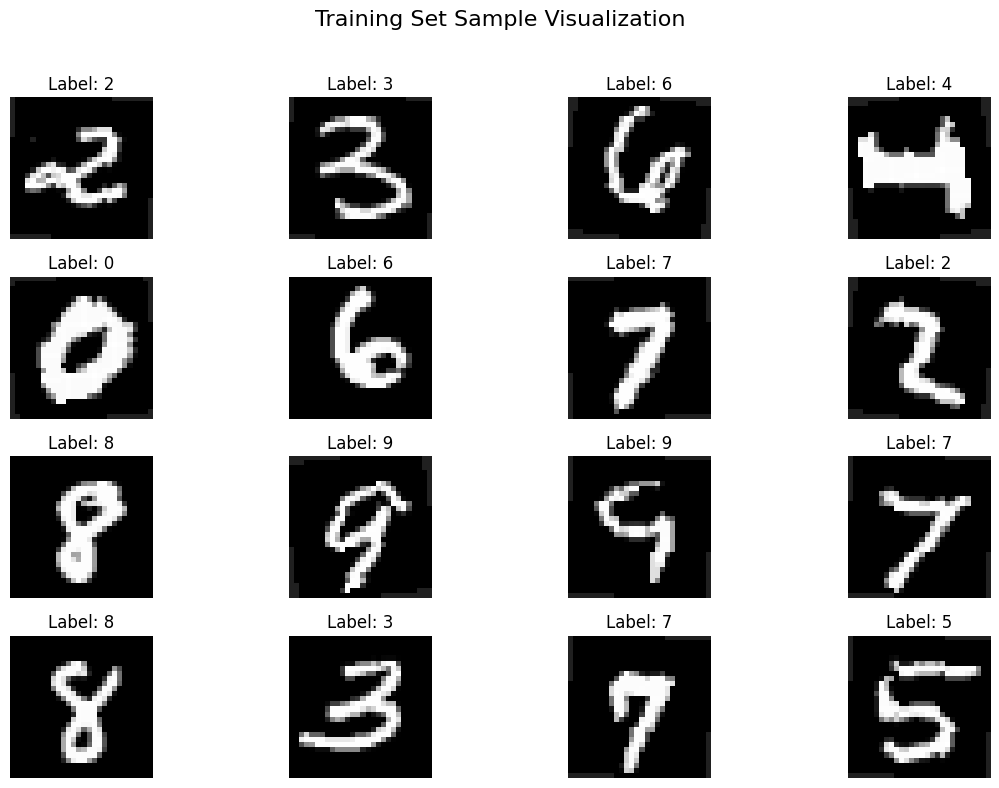


===== Validation Set Basic Information =====
Number of samples: 8400


Number of classes: 10
Class 0: 827 samples (9.85%)
Class 1: 937 samples (11.15%)
Class 2: 835 samples (9.94%)
Class 3: 870 samples (10.36%)
Class 4: 814 samples (9.69%)
Class 5: 759 samples (9.04%)
Class 6: 827 samples (9.85%)
Class 7: 880 samples (10.48%)
Class 8: 813 samples (9.68%)
Class 9: 838 samples (9.98%)


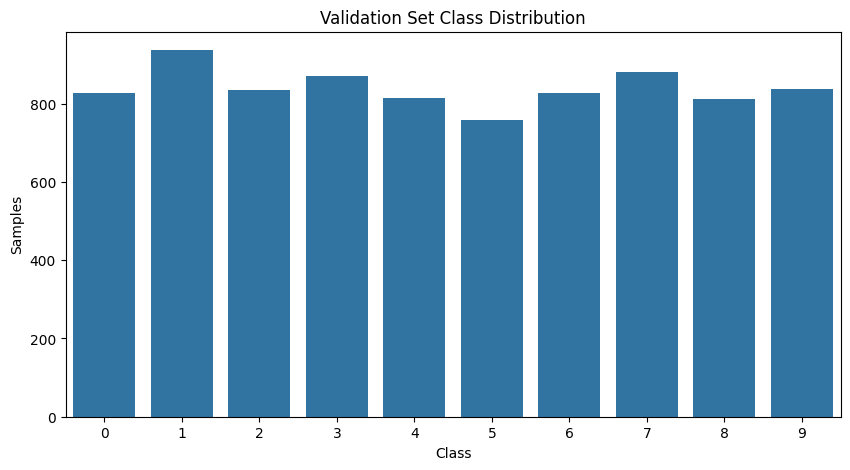


===== Test Set Basic Information =====
Number of samples: 28000


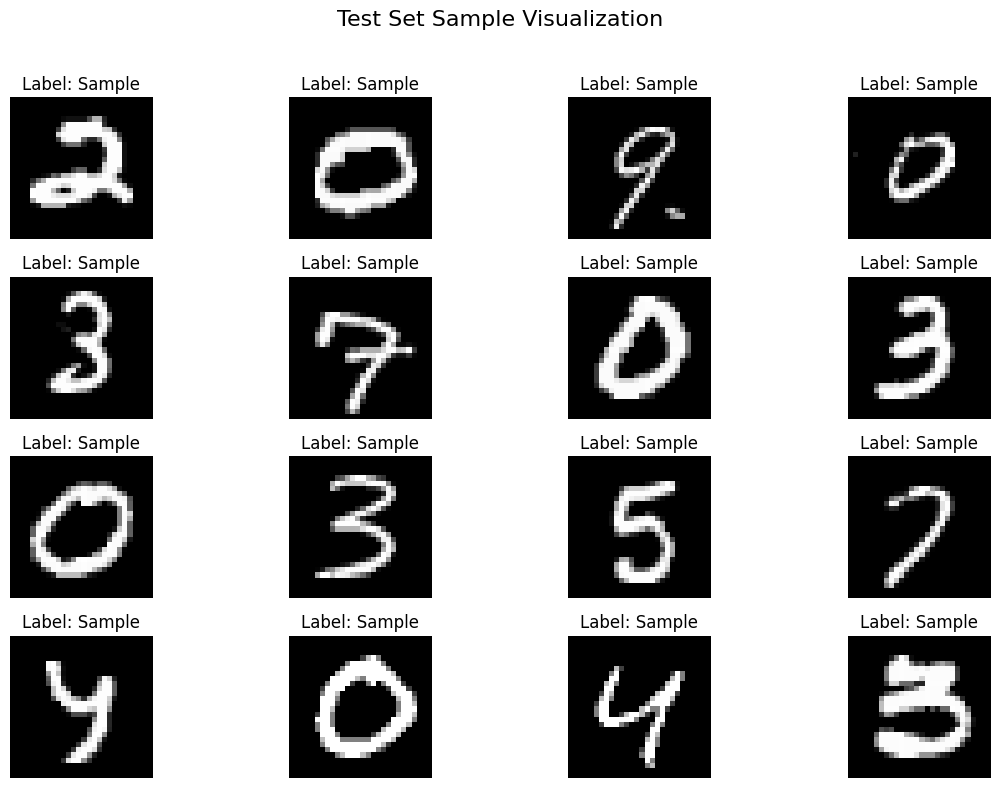

In [6]:
# Create Dataset instances
train_dataset = DigitDataset(train_data, transform=train_transform, has_labels=True)
val_dataset = DigitDataset(val_data, transform=test_transform, has_labels=True)
test_dataset = DigitDataset(test_data, transform=test_transform, has_labels=False)

# Explore datasets
explore_dataset(train_dataset, "Training Set")
explore_dataset(val_dataset, "Validation Set", show_images=False)
explore_dataset(test_dataset, "Test Set")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_loss = float('inf')
    best_accuracy = 0.0
    epochs_no_improve = 0
    early_stop_patience = 5

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
            print("✅ Model improved, saving.")
        else:
            epochs_no_improve += 1
            print(f"⏳ Early stop counter: {epochs_no_improve}/{early_stop_patience}")
            if epochs_no_improve >= early_stop_patience:
                print("🛑 Early stopping triggered.")
                break

    print(f"Training complete. Best Val Accuracy: {best_accuracy:.4f}")


In [10]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20
)


Epoch 1 - Train Loss: 0.2333 | Val Loss: 0.0651 | Val Acc: 0.9801


✅ Model improved, saving.


Epoch 2 - Train Loss: 0.0880 | Val Loss: 0.0447 | Val Acc: 0.9854


✅ Model improved, saving.


Epoch 3 - Train Loss: 0.0730 | Val Loss: 0.0357 | Val Acc: 0.9881


✅ Model improved, saving.


Epoch 4 - Train Loss: 0.0638 | Val Loss: 0.0341 | Val Acc: 0.9888


✅ Model improved, saving.


Epoch 5 - Train Loss: 0.0545 | Val Loss: 0.0345 | Val Acc: 0.9894


✅ Model improved, saving.


Epoch 6 - Train Loss: 0.0495 | Val Loss: 0.0317 | Val Acc: 0.9908


✅ Model improved, saving.


Epoch 7 - Train Loss: 0.0451 | Val Loss: 0.0311 | Val Acc: 0.9911


✅ Model improved, saving.


Epoch 8 - Train Loss: 0.0417 | Val Loss: 0.0281 | Val Acc: 0.9918


✅ Model improved, saving.


Epoch 9 - Train Loss: 0.0392 | Val Loss: 0.0287 | Val Acc: 0.9904
⏳ Early stop counter: 1/5


Epoch 10 - Train Loss: 0.0362 | Val Loss: 0.0259 | Val Acc: 0.9921


✅ Model improved, saving.


Epoch 11 - Train Loss: 0.0352 | Val Loss: 0.0261 | Val Acc: 0.9924


✅ Model improved, saving.


Epoch 12 - Train Loss: 0.0313 | Val Loss: 0.0283 | Val Acc: 0.9915
⏳ Early stop counter: 1/5


Epoch 13 - Train Loss: 0.0322 | Val Loss: 0.0259 | Val Acc: 0.9927


✅ Model improved, saving.


Epoch 14 - Train Loss: 0.0286 | Val Loss: 0.0242 | Val Acc: 0.9935


✅ Model improved, saving.


Epoch 15 - Train Loss: 0.0282 | Val Loss: 0.0271 | Val Acc: 0.9918
⏳ Early stop counter: 1/5


Epoch 16 - Train Loss: 0.0266 | Val Loss: 0.0253 | Val Acc: 0.9926
⏳ Early stop counter: 2/5


Epoch 17 - Train Loss: 0.0249 | Val Loss: 0.0256 | Val Acc: 0.9939


✅ Model improved, saving.


Epoch 18 - Train Loss: 0.0203 | Val Loss: 0.0236 | Val Acc: 0.9936
⏳ Early stop counter: 1/5


Epoch 19 - Train Loss: 0.0177 | Val Loss: 0.0249 | Val Acc: 0.9926
⏳ Early stop counter: 2/5


Epoch 20 - Train Loss: 0.0164 | Val Loss: 0.0245 | Val Acc: 0.9932
⏳ Early stop counter: 3/5
Training complete. Best Val Accuracy: 0.9939


In [11]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Prediction on test data
def predict_test(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in test_loader:
            if isinstance(images, tuple):  # In case of (img, None)
                images = images[0]
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Run prediction
test_predictions = predict_test(model, test_loader, device)

# Save to submission file
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predictions) + 1),
    'Label': test_predictions
})
submission.to_csv('submission.csv', index=False)

# Show first few predictions
print("Sample predictions:")
print(submission.head())

Sample predictions:


   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
